<center>
    <h1> Natural Language Processing</h1>
    <h2> Style Change Detection </h2>
    <a href="mailto:ildebrando.simeoni@studio.unibo.it">Ildebrando Simeoni</a>, <a href="mailto:diego.biagini2@studio.unibo.it">Diego Biagini</a>, <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a>
</center>

<br>

\begin{array}{clccc}
\hline
\textbf{Model} & \textbf{Layers} & \boldsymbol{F_1} \textbf{ subtask 1} & \boldsymbol{F_1} \textbf{ subtask 2} & \boldsymbol{F_1} \textbf{ subtask 3} \\
\hline
m_1^1 & \text{BERT, global max-pooling, classification head} & 0.72 & \dots & \dots \\
m_2^1 & \text{BERT, global avg-pooling, classification head} & 0.71 & \dots & \dots \\
m_3^1 & \text{BERT, global max-pooling, dense layer, classification head} & 0.71 & \dots & \dots \\
m_4^1 & \text{BERT, (conv1D layer, max-pooling) $\times$ 3, flatten, classification head} & 0.68 & \dots & \dots \\
\hline
\end{array}

# Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 7.6 MB 50.1 MB/s 
     |████████████████████████████████| 182 kB 74.0 MB/s 


In [2]:
import os
import pandas as pd
import json
from pandas import json_normalize
import re
from wordcloud import WordCloud, STOPWORDS
import random
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report

In [3]:
drive.mount("/content/drive")
!unzip /content/drive/MyDrive/pan22.zip
#!unzip /content/drive/MyDrive/Magistrale/Second_year/NLP/Progetto/pan22.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset3/train/truth-problem-5500.json  
  inflating: dataset3/train/truth-problem-5501.json  
  inflating: dataset3/train/truth-problem-5502.json  
  inflating: dataset3/train/truth-problem-5503.json  
  inflating: dataset3/train/truth-problem-5504.json  
  inflating: dataset3/train/truth-problem-5505.json  
  inflating: dataset3/train/truth-problem-5506.json  
  inflating: dataset3/train/truth-problem-5507.json  
  inflating: dataset3/train/truth-problem-5508.json  
  inflating: dataset3/train/truth-problem-5509.json  
  inflating: dataset3/train/truth-problem-551.json  
  inflating: dataset3/train/truth-problem-5510.json  
  inflating: dataset3/train/truth-problem-5511.json  
  inflating: dataset3/train/truth-problem-5512.json  
  inflating: dataset3/train/truth-problem-5513.json  
  inflating: dataset3/train/truth-problem-5514.json  
  inflating: dataset3/train/truth-problem-5515.json  
  inflating: dataset3/train/truth

#Utility functions

In [4]:
# Sets reproducibility.
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.config.experimental.enable_op_determinism()
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# Setting seed.
set_reproducibility(seed = 42)

In [5]:
def create_dataframe(directory):

  train_set = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.json'):
            train_set.append(f)

  train_set.sort(key=lambda f: int(re.sub('\D', '', f))) #sorting alphabetically files by name in order to have the correct order

  data = []
  for name in train_set:
    with open(name) as json_data:
      data_dict = json.load(json_data)
      data.append(data_dict)

  df = json_normalize(data)
  
  train_set_text = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if f.endswith('.txt'):
            train_set_text.append(f)

  train_set_text.sort(key=lambda f: int(re.sub('\D', '', f)))

  text_list = []
  for file in train_set_text:
    with open(file) as f:
      content = f.read()
      text_list.append(content)

  df['input_text'] = text_list

  splitted_text = []
  for text in df['input_text']:
    split = text.splitlines()
    splitted_text.append(split)

  df['splitted_text'] = pd.Series(splitted_text)

  #Sanity check, checking if we have splitted correctly (according to the datset) the input text 
  for i in range(len(df.index)):
    if len(df['splitted_text'].iloc[i]) != len(df['paragraph-authors'].iloc[i]):
      print("we have a problem at row: ",i)
    
  return df

In [6]:
def data_inspection(data, wordCloud : bool = False):  
  print(f"Dataset size: {data.shape}")
  print(f"Dataset columns: {data.columns.values}")
  print(f"Main sources: {data['site'].unique()}")
  print(f"Number of questions per source:\n {data.groupby(['site'])['site'].count()}")
  print(f"Average length of the text: {data['input_text'].apply(len).mean()}") 
  print(f"Possible number of authors: {data['authors'].unique()}") 
  if wordCloud:
    wordcloud = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(data['input_text'])) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.show()

In [34]:
# Figures folder.
figures_path = os.path.join(os.getcwd(), "figures")
if not os.path.exists(figures_path): 
  os.makedirs(figures_path)

# Plots classes distribution.
def plot_classes_distribution(classes, counts, filename, figures_path = figures_path):

  # Width of each bar.
  bar_w = 0.45

  # Plot.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))
  bars = ax.bar(classes[0] - bar_w / 2, counts[0], width = bar_w, label = "Without preprocessing")
  bars = ax.bar(classes[1] + bar_w / 2, counts[1], width = bar_w, label = "With preprocessing")

  # Setting plot attributes.
  ax.set_xlabel("Class")
  ax.set_ylabel("Percentage (%)")
  ax.set_xticks(np.arange(0, len(classes[0]), 1))
  ax.legend()

  fig.savefig(f"{figures_path}/{filename}.pdf", bbox_inches = "tight")
  plt.show()

In [33]:
# Splits dataset in all possible couples of paragraphs/sentences.
def preprocess_with_data_augmentation(documents, authors, tokenizer, max_length, total_upsampling = False, max_samples = None):

  # Tensors to be fed to a model.
  token_ids = []
  attention_masks = []
  token_type_ids = []
  labels = []

  # Splitting data.
  for document, author in zip(documents, authors):
    for i in range(len(document)):

      # Checking data augmentation type.
      if total_upsampling:
        start = 0
      else:
        start = i + 1

      for j in range(start, len(document)):
        if i != j:
          encoding_dict = tokenizer.encode_plus(document[i], 
                                                document[j], 
                                                add_special_tokens = True, 
                                                truncation = True, 
                                                padding = "max_length", 
                                                max_length = max_length, 
                                                return_attention_mask = True,
                                                return_token_type_ids = True,
                                                return_tensors = "tf")
          
          token_ids.append(encoding_dict["input_ids"]) 
          attention_masks.append(encoding_dict["attention_mask"])
          token_type_ids.append(encoding_dict["token_type_ids"])

          if author[i] != author[j]:
            labels.append(1)
          else:
            labels.append(0)

  # Creating TensorFlow tensors.
  token_ids = tf.concat(token_ids, axis = 0)
  attention_masks = tf.concat(attention_masks, axis = 0)
  token_type_ids = tf.concat(token_type_ids, axis = 0)
  labels = tf.concat(labels, axis = 0)

  # Sampling from tensors to select max_samples samples.
  if max_samples != None:
    idx = []
    idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
    idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
    token_ids = token_ids.numpy()[idx]
    attention_masks = attention_masks.numpy()[idx]
    token_type_ids = token_type_ids.numpy()[idx]
    labels = labels.numpy()[idx]

  # Returning tensors.
  return token_ids, labels, attention_masks, token_type_ids

# Splits dataset in couples of consecutive paragraphs/sentences.
def preprocess_without_data_augmentation(splitted_text, changes, tokenizer, max_length, max_samples = None):

  # Tensors to be fed to the model.
  token_ids = []
  attention_masks = []
  token_type_ids = []
  labels = tf.convert_to_tensor([item for sublist in changes for item in sublist])

  # Splitting data.
  for document in splitted_text:
    for i in range(len(document)):
      if i < len(document) - 1:
        encoding_dict = tokenizer.encode_plus(document[i], 
                                              document[i + 1], 
                                              add_special_tokens = True, 
                                              truncation = True, 
                                              padding = "max_length", 
                                              max_length = max_length, 
                                              return_attention_mask = True, 
                                              return_token_type_ids = True,
                                              return_tensors = "tf")
        
        token_ids.append(encoding_dict["input_ids"]) 
        attention_masks.append(encoding_dict["attention_mask"])
        token_type_ids.append(encoding_dict["token_type_ids"])

  # Creating TensorFlow tensors.
  token_ids = tf.concat(token_ids, axis = 0)
  attention_masks = tf.concat(attention_masks, axis = 0)
  token_type_ids = tf.concat(token_type_ids, axis = 0)

  # Sampling from tensors to select max_samples samples.
  if max_samples != None:
    idx = []
    idx.extend(list(np.random.choice(np.where(labels == 0)[0], max_samples, replace = False)))
    idx.extend(list(np.random.choice(np.where(labels == 1)[0], max_samples, replace = False)))
    token_ids = token_ids.numpy()[idx]
    attention_masks = attention_masks.numpy()[idx]
    token_type_ids = token_type_ids.numpy()[idx]
    labels = labels.numpy()[idx]

  # Returning tensors.
  return token_ids, labels, attention_masks, token_type_ids

In [9]:
# Creates the BERT model.
def create_bert_model(encoder, input_shape, n_classes, layers):

  # Input layers.
  input_ids = tf.keras.layers.Input(shape = input_shape, name = "input_ids", dtype = "int32")
  masks = tf.keras.layers.Input(shape = input_shape, name = "attention_masks", dtype = "int32")
  token_type_ids = tf.keras.layers.Input(shape = input_shape, name = "token_type_ids", dtype = "int32")

  # Tensor 0 is last_hidden_state.
  embeddings = encoder(input_ids, attention_mask = masks, token_type_ids = token_type_ids)[0]

  # Adding layers.
  for i in range(len(layers)):
    if i == 0:
      X = layers[0](embeddings)
    else:
      X = layers[i](X)

  # Classification head.
  y = tf.keras.layers.Dense(n_classes, activation = "softmax", name = "outputs")(X)

  # Model.
  model = tf.keras.Model(inputs = [input_ids, masks, token_type_ids], outputs = y)

  # Return model.
  return model

In [10]:
# Computes index of the most similar row.
def get_row_with_max_similarity(matrix, curr):
  def element_wise_similarity(row_1, row_2):
    return np.sum(np.array(row_1) == np.array(row_2)) / len(row_1)
  return np.argmax([element_wise_similarity(matrix[curr], matrix[i]) for i in range(len(matrix)) if i != curr])

# Labeling function.
def labeling(authors, matrix):

  pred = [0] * len(authors)
  to_discard = []
  new_label = 1

  # Labeling.
  for i in range(len(authors)):
    if i not in to_discard:
      for j in range(len(authors)):
        if j not in to_discard:
          if matrix[i][j] == 0:
            if new_label > 5:
              pred[i] = pred[get_row_with_max_similarity(matrix, i)]
              pred[j] = pred[get_row_with_max_similarity(matrix, j)]
            else:
              pred[i] = new_label
              pred[j] = new_label
            to_discard.append(i)
            to_discard.append(j)
      if new_label < 5:
        new_label = new_label + 1
  
  # Returning pred.
  return pred


# Computes "paragraph-authors" list from model's output.
def compute_authors_pred_list(data, predictions):

  y_pred = []

  # Labeling.
  for authors in data:
    
    # Extracting changes for current authors list.
    solution = predictions[:len(authors) * (len(authors) - 1)]
    predictions = predictions[len(authors) * (len(authors) - 1):]

    # Adding label 0 to each (paragraph-x, paragraph-x) pair.
    for i in range(len(authors)): 
      solution = np.insert(solution, obj = i + (i * len(authors)), values = 0)

    # Reshaping output to be a matrix.
    solution = np.reshape(solution, (-1, len(authors)))

    # Labeling.
    y_pred.extend(labeling(authors, solution))

  # Returning y_pred.
  return y_pred

In [11]:
# Saves solutions.
def save_solution_files(task, solution_folder, df, predictions):

  # Tasks 1 and 3.
  if task == 1 or task == 3:

    # Creating lists of solutions.
    for id_problem, changes in enumerate(df["changes"].values):
      
      # Solution.
      solution = predictions[:len(changes)]
      predictions = predictions[len(changes):]

      # Saving solution.
      with open(f"{solution_folder}/solution-problem-{id_problem + 1}.json", "w") as file:
        file.write("{" + "\n" + '\"changes\": {}'.format(solution) + "\n" + "}")

  # Task 2.
  elif task == 2:

    # Creating lists of solutions.
    for id_problem, authors in enumerate(df["paragraph-authors"].values):
      
      # Solution.
      solution = predictions[:len(authors)]
      predictions = predictions[len(authors):]

      # Saving solution.
      with open(f"{solution_folder}/solution-problem-{id_problem + 1}.json", "w") as file:
        file.write("{" + "\n" + '\"paragraph-authors\": {}'.format(solution) + "\n" + "}")

In [12]:
# Learning rate schedule.
class LearningRateSchedule(tf.keras.callbacks.Callback):

  # Constructor.
  def __init__(self, model, n, reduction):
    self.model = model
    self.n = n
    self.reduction = reduction
    
  # Initializes step attribute.
  def on_train_begin(self, logs = None):
    self.step = 0

  # Reducing learning rate after specific number of batches.
  def on_train_batch_end(self, batch, logs = None):
    self.step += 1
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    if self.step % self.n == 0:
      new_lr = lr * (1.0 - self.reduction / 100)         
      tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
      print("\nThe learning rate was adjusted from {:.4e} to {:.4e}.".format(lr, new_lr))

#Subtask 1

##Data Inspection

In [13]:
train_directory = '/content/dataset1/train'
df_train = create_dataframe(train_directory)
df_train.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,2,serverfault.com.7z,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 2]",I use squid on RHEL6 and I want that authentic...,[I use squid on RHEL6 and I want that authenti...
1,2,superuser.com.7z,1,"[0, 0, 0, 1, 0, 0]","[1, 1, 1, 1, 2, 2, 2]","""This behavior can occur if Windows has detect...","[""This behavior can occur if Windows has detec..."
2,2,dba.stackexchange.com.7z,1,"[0, 0, 1, 0, 0]","[1, 1, 1, 2, 2, 2]",Let that thing rollback. There's nothing you c...,[Let that thing rollback. There's nothing you ...
3,2,superuser.com.7z,1,"[0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 2, 2, 2, 2]",Is there a way to set up tests/analysis of you...,[Is there a way to set up tests/analysis of yo...
4,2,serverfault.com.7z,1,"[0, 0, 0, 1]","[1, 1, 1, 1, 2]",I have a single OEL/RHEL 5.3 server with a 'so...,[I have a single OEL/RHEL 5.3 server with a 's...


In [14]:
data_inspection(df_train)

Dataset size: (1400, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'dba.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'computergraphics.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'codereview.stackexchange.com.7z' 'devops.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'cseducators.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             74
computergraphics.stackexchange.com.7z        4
cseducators.stackexchange.com.7z             3
cstheory.stackexchange.com.7z               15
datascience.stackexchange.com.7z            32
dba.stackexchange.com.7z                   128
devops.stackexchange.com.7z                  4
gamedev.stackexchange.com.7z               100
networkengineering.stackexchange.com.7z     36
r

In [15]:
valid_directory = '/content/dataset1/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,2,serverfault.com.7z,1,"[0, 0, 1, 0, 0]","[1, 1, 1, 2, 2, 2]",If you can handle a slight delay in the data y...,[If you can handle a slight delay in the data ...
1,2,serverfault.com.7z,1,"[0, 1, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 2, 2]",I figured i'd share my method which worked to ...,[I figured i'd share my method which worked to...
2,2,networkengineering.stackexchange.com.7z,1,"[1, 0, 0, 0]","[1, 2, 2, 2, 2]",This is not possible the way I want to impleme...,[This is not possible the way I want to implem...
3,2,serverfault.com.7z,1,"[0, 0, 0, 0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]",We have central HQ building and a lot of small...,[We have central HQ building and a lot of smal...
4,2,cstheory.stackexchange.com.7z,1,"[1, 0, 0]","[1, 2, 2, 2]",Moser's proof of the constructive Lovasz Local...,[Moser's proof of the constructive Lovasz Loca...


In [16]:
data_inspection(df_valid)

Dataset size: (300, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'networkengineering.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'superuser.com.7z'
 'gamedev.stackexchange.com.7z' 'raspberrypi.stackexchange.com.7z'
 'datascience.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'dba.stackexchange.com.7z' 'computergraphics.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             19
computergraphics.stackexchange.com.7z        1
cseducators.stackexchange.com.7z             1
cstheory.stackexchange.com.7z                5
datascience.stackexchange.com.7z             8
dba.stackexchange.com.7z                    27
devops.stackexchange.com.7z                  1
gamedev.stackexchange.com.7z                21
networkengineering.stackexchange.com.7z      7
ras

## Data Preprocessing

In [17]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [18]:
# Max input length.
MAX_LENGTH = 256

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_with_data_augmentation(df_train["splitted_text"].values, df_train["paragraph-authors"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_without_data_augmentation(df_valid["splitted_text"].values, df_valid["changes"].values, tokenizer, MAX_LENGTH)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

train_ids: (30000, 256), train_labels: (30000,), train_masks: (30000, 256), train_type_ids: (30000, 256).
valid_ids: (2141, 256), valid_labels: (2141,), valid_masks: (2141, 256), valid_type_ids: (2141, 256).


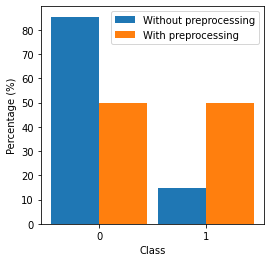

In [35]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask1_m1_distribution")

## Models Definition and Training

In [20]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [21]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m1 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
# Summary.
m1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [23]:
# Compiling.
m1.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m1, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m1.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m1.save_weights("subtask_1_m1.h5")

Epoch 1/2


 374/1875 [====>.........................] - ETA: 21:11 - loss: 0.5984 - accuracy: 0.6741
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:07 - loss: 0.5455 - accuracy: 0.7129
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:48 - loss: 0.5040 - accuracy: 0.7403
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:25 - loss: 0.4724 - accuracy: 0.7619
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4429 - accuracy: 0.7796
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1635s 867ms/step - loss: 0.4429 - accuracy: 0.7796
Epoch 2/2
 374/1875 [====>.........................] - ETA: 21:47 - loss: 0.1789 - accuracy: 0.9347
The learning rate was adjusted from 1.6384e-05 t

### $m_2^1$

In [24]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m2 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
# Summary.
m2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [26]:
# Compiling.
m2.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m2, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m2.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m2.save_weights("subtask_1_m2.h5")

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:13 - loss: 0.5903 - accuracy: 0.6678
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:43 - loss: 0.5314 - accuracy: 0.7145
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:09 - loss: 0.4839 - accuracy: 0.7503
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:35 - loss: 0.4451 - accuracy: 0.7752
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.7965
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1682s 892ms/step - loss: 0.4107 - accuracy: 0.7965
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:21 - loss: 0.1201 - accuracy: 0.9547
The learning rate was adjusted from 1.6384e-05 t

### $m_3^1$

In [27]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m3 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
# Summary.
m3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [29]:
# Compiling.
m3.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m3, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m3.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m3.save_weights("subtask_1_m3.h5")

Epoch 1/2


 374/1875 [====>.........................] - ETA: 21:28 - loss: 0.5914 - accuracy: 0.6758
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:10 - loss: 0.5393 - accuracy: 0.7134
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 10:48 - loss: 0.4990 - accuracy: 0.7403
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:25 - loss: 0.4655 - accuracy: 0.7636
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.7831
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1631s 865ms/step - loss: 0.4342 - accuracy: 0.7831
Epoch 2/2
 374/1875 [====>.........................] - ETA: 21:47 - loss: 0.1687 - accuracy: 0.9358
The learning rate was adjusted from 1.6384e-05 t

### $m_4^1$

In [30]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m4 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [31]:
# Summary.
m4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [32]:
# Compiling.
m4.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m4, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m4.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m4.save_weights("subtask_1_m4.h5")

Epoch 1/2


 374/1875 [====>.........................] - ETA: 22:15 - loss: 0.6173 - accuracy: 0.6347
The learning rate was adjusted from 5.0000e-05 to 4.0000e-05.
 749/1875 [==========>...................] - ETA: 16:45 - loss: 0.5673 - accuracy: 0.6806
The learning rate was adjusted from 4.0000e-05 to 3.2000e-05.
1124/1875 [================>.............] - ETA: 11:11 - loss: 0.5268 - accuracy: 0.7142
The learning rate was adjusted from 3.2000e-05 to 2.5600e-05.
1499/1875 [======================>.......] - ETA: 5:36 - loss: 0.4955 - accuracy: 0.7380
The learning rate was adjusted from 2.5600e-05 to 2.0480e-05.
1874/1875 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.7592
The learning rate was adjusted from 2.0480e-05 to 1.6384e-05.
1875/1875 [==============================] - 1694s 895ms/step - loss: 0.4649 - accuracy: 0.7592
Epoch 2/2
 374/1875 [====>.........................] - ETA: 22:25 - loss: 0.2050 - accuracy: 0.9168
The learning rate was adjusted from 1.6384e-05 t

## Model Testing

### $m_1^1$

In [36]:
# Validation test.
y_pred_m1 = np.argmax(m1.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m1_pred.npy", y_pred_m1)
np.save("subtask1_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m1))

67/67 [==============================] - 39s 521ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1841
           1       0.42      0.81      0.55       300

    accuracy                           0.82      2141
   macro avg       0.69      0.81      0.72      2141
weighted avg       0.89      0.82      0.84      2141



### $m_2^1$

In [37]:
# Validation test.
y_pred_m2 = np.argmax(m2.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m2_pred.npy", y_pred_m2)
np.save("subtask1_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m2))

67/67 [==============================] - 38s 527ms/step
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1841
           1       0.41      0.82      0.55       300

    accuracy                           0.81      2141
   macro avg       0.69      0.81      0.71      2141
weighted avg       0.89      0.81      0.83      2141



### $m_3^1$

In [38]:
# Validation test.
y_pred_m3 = np.argmax(m3.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m3_pred.npy", y_pred_m3)
np.save("subtask1_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m3))

67/67 [==============================] - 38s 532ms/step
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1841
           1       0.40      0.82      0.54       300

    accuracy                           0.81      2141
   macro avg       0.69      0.81      0.71      2141
weighted avg       0.89      0.81      0.83      2141



### $m_4^1$

In [39]:
# Validation test.
y_pred_m4 = np.argmax(m4.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask1_m4_pred.npy", y_pred_m4)
np.save("subtask1_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m4))

67/67 [==============================] - 40s 543ms/step
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1841
           1       0.37      0.81      0.51       300

    accuracy                           0.78      2141
   macro avg       0.66      0.79      0.68      2141
weighted avg       0.88      0.78      0.81      2141



#Subtask 2

## Data Inspection

In [ ]:
train_directory = '/content/dataset2/train'
df_train = create_dataframe(train_directory)
df_train.head()

In [ ]:
data_inspection(df_train)

In [ ]:
valid_directory = '/content/dataset2/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

In [ ]:
data_inspection(df_valid)

## Data preprocessing

In [ ]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Max input length.
MAX_LENGTH = 256

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_without_data_augmentation(df_train["splitted_text"].values, df_train["changes"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_with_data_augmentation(df_valid["splitted_text"].values, df_valid["paragraph-authors"].values, tokenizer, MAX_LENGTH, total_upsampling = True)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask2_m1_distribution")

## Models Definition and Training

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m11 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m11.summary()

In [ ]:
# Compiling.
m11.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m11, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m11.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m11.save_weights("subtask_2_m1.h5")

### $m_2^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m22 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m22.summary()

In [ ]:
# Compiling.
m22.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m22, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m22.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m22.save_weights("subtask_2_m2.h5")

### $m_3^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m33 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m33.summary()

In [ ]:
# Compiling.
m33.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m33, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m33.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m33.save_weights("subtask_2_m3.h5")

### $m_4^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m44 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m44.summary()

In [ ]:
# Compiling.
m44.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m44, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m44.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m44.save_weights("subtask_2_m4.h5")

## Model Testing

In [ ]:
# Computing uni-dimensional list of paragraph authors.
valid_labels = [author for authors in df_valid["paragraph-authors"].values for author in authors]

### $m_1^1$

In [ ]:
# Validation test.
y_pred_m11 = np.argmax(m11.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m11 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m11)

# Saving true and predicted labels.
np.save("subtask2_m1_pred.npy", y_pred_m11)
np.save("subtask2_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m11))

### $m_2^1$

In [ ]:
# Validation test.
y_pred_m22 = np.argmax(m22.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m22 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m22)

# Saving true and predicted labels.
np.save("subtask2_m2_pred.npy", y_pred_m22)
np.save("subtask2_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m22))

### $m_3^1$

In [ ]:
# Validation test.
y_pred_m33 = np.argmax(m33.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m33 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m33)

# Saving true and predicted labels.
np.save("subtask2_m3_pred.npy", y_pred_m33)
np.save("subtask2_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m33))

### $m_4^1$

In [ ]:
# Validation test.
y_pred_m44 = np.argmax(m44.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Casting y_pred to be list of paragraph-authors instead of list of changes.
y_pred_m44 = compute_authors_pred_list(df_valid["paragraph-authors"].values, y_pred_m44)

# Saving true and predicted labels.
np.save("subtask2_m4_pred.npy", y_pred_m44)
np.save("subtask2_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m44))

#Subtask 3


##Data Inspection

In [ ]:
train_directory = '/content/dataset3/train'
df_train = create_dataframe(train_directory)
df_train.head()

we have a problem at row:  1194


,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,5,serverfault.com.7z,1,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]","[1, 2, 1, 1, 3, 2, 2, 3, 4, 5, 5, 2]",Everything else equals I would say it being mo...,[Everything else equals I would say it being m...
1,1,gamedev.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",I also apologize for the lack of a 'decent' ti...,[I also apologize for the lack of a 'decent' t...
2,5,superuser.com.7z,1,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]","[1, 2, 3, 1, 1, 4, 5, 5, 1, 3, 3, 2, 2, 2, 1]",And updates should not need to touch /home/ an...,[And updates should not need to touch /home/ a...
3,1,computergraphics.stackexchange.com.7z,0,"[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]","But v1,v2,v4 and v5 would have non-zero normal...","[But v1,v2,v4 and v5 would have non-zero norma..."
4,3,superuser.com.7z,1,"[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, ...","[1, 2, 1, 3, 2, 2, 3, 3, 2, 2, 1, 2, 2, 2, 3, ...",Now run this command to stop Windows from inst...,[Now run this command to stop Windows from ins...


In [ ]:
# Element at index 4 of df_train["splitted_text"][1194] is empty and needs to be removed.
del df_train["splitted_text"][1194][4]

In [ ]:
data_inspection(df_train)

Dataset size: (7000, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'gamedev.stackexchange.com.7z' 'superuser.com.7z'
 'computergraphics.stackexchange.com.7z'
 'datascience.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'raspberrypi.stackexchange.com.7z'
 'dba.stackexchange.com.7z' 'cstheory.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z' 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             281
computergraphics.stackexchange.com.7z        23
cseducators.stackexchange.com.7z             57
cstheory.stackexchange.com.7z                97
datascience.stackexchange.com.7z            157
dba.stackexchange.com.7z                    352
devops.stackexchange.com.7z                  28
gamedev.stackexchange.com.7z                482
networkengineering.stackexchange.com.7z  

In [ ]:
valid_directory = '/content/dataset3/validation'
df_valid = create_dataframe(valid_directory)
df_valid.head()

,authors,site,multi-author,changes,paragraph-authors,input_text,splitted_text
0,4,serverfault.com.7z,1,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[1, 2, 1, 3, 3, 3, 1, 3, 4, 4, 1, 2, 3, 1, 1, 4]",And here is the question: why do I have to use...,[And here is the question: why do I have to us...
1,2,superuser.com.7z,1,"[1, 1, 1, 0, 0, 1, 0]","[1, 2, 1, 2, 2, 2, 1, 1]",Remove the Day column and combine the Date and...,[Remove the Day column and combine the Date an...
2,3,superuser.com.7z,1,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, ...","(I will use the ""&"" to execute the command in ...","[(I will use the ""&"" to execute the command in..."
3,2,superuser.com.7z,1,"[1, 0, 0, 0, 1, 1, 0]","[1, 2, 2, 2, 2, 1, 2, 2]",In the advanced settings of openvpn i have cho...,[In the advanced settings of openvpn i have ch...
4,4,superuser.com.7z,1,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, ...","[1, 1, 2, 1, 3, 4, 1, 2, 3, 1, 1, 2, 1, 3, 1, ...",Every single device does not exceed the limit ...,[Every single device does not exceed the limit...


In [ ]:
data_inspection(df_valid)

Dataset size: (1500, 7)
Dataset columns: ['authors' 'site' 'multi-author' 'changes' 'paragraph-authors'
 'input_text' 'splitted_text']
Main sources: ['serverfault.com.7z' 'superuser.com.7z' 'dba.stackexchange.com.7z'
 'cstheory.stackexchange.com.7z' 'codereview.stackexchange.com.7z'
 'gamedev.stackexchange.com.7z' 'computergraphics.stackexchange.com.7z'
 'raspberrypi.stackexchange.com.7z'
 'networkengineering.stackexchange.com.7z'
 'cseducators.stackexchange.com.7z' 'datascience.stackexchange.com.7z'
 'devops.stackexchange.com.7z']
Number of questions per source:
 site
codereview.stackexchange.com.7z             50
computergraphics.stackexchange.com.7z        4
cseducators.stackexchange.com.7z             8
cstheory.stackexchange.com.7z               17
datascience.stackexchange.com.7z            22
dba.stackexchange.com.7z                    86
devops.stackexchange.com.7z                  6
gamedev.stackexchange.com.7z                92
networkengineering.stackexchange.com.7z     34
r

## Data Preprocessing

In [ ]:
# Model checkpoint.
checkpoint = "bert-base-cased"

# Getting tokenizer.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Max input length.
MAX_LENGTH = 64

# Number of samples per class.
MAX_SAMPLES = 15000

# Splitting data.
train_ids, train_labels, train_masks, train_type_ids = preprocess_without_data_augmentation(df_train["splitted_text"].values, df_train["changes"].values, tokenizer, MAX_LENGTH, max_samples = MAX_SAMPLES)
valid_ids, valid_labels, valid_masks, valid_type_ids = preprocess_without_data_augmentation(df_valid["splitted_text"].values, df_valid["changes"].values, tokenizer, MAX_LENGTH)

# Printing shapes.
print(f"train_ids: {train_ids.shape}, train_labels: {train_labels.shape}, train_masks: {train_masks.shape}, train_type_ids: {train_type_ids.shape}.")
print(f"valid_ids: {valid_ids.shape}, valid_labels: {valid_labels.shape}, valid_masks: {valid_masks.shape}, valid_type_ids: {valid_type_ids.shape}.")

In [ ]:
# Computing classes distributions.
classes_without_upsampling, counts_without_upsampling = np.unique([item for sublist in df_train["changes"] for item in sublist], return_counts = True)
classes_with_upsampling, counts_with_upsampling = np.unique(train_labels, return_counts = True)

# Normalizing.
counts_without_upsampling = counts_without_upsampling / np.sum(counts_without_upsampling) * 100
counts_with_upsampling = counts_with_upsampling / np.sum(counts_with_upsampling) * 100

# Plot classes distribution.
plot_classes_distribution([classes_without_upsampling, classes_with_upsampling], [counts_without_upsampling, counts_with_upsampling], "subtask3_m1_distribution")

## Models Definition and Training

In [ ]:
# Training hyperparameters.
LR = 5e-5
BATCH_SIZE = 16
N_EPOCHS = 2

# Learning rate schedule hyperparameters.
N_DECREASE_LR = 5
LR_REDUCTION = 20

### $m_1^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D()]

# Creating the model.
m111 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m111.summary()

In [ ]:
# Compiling.
m111.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m111, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m111.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m111.save_weights("subtask_3_m1.h5")

### $m_2^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalAveragePooling1D()]

# Creating the model.
m222 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m222.summary()

In [ ]:
# Compiling.
m222.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m222, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m222.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m222.save_weights("subtask_3_m2.h5")

### $m_3^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.GlobalMaxPool1D(),
          tf.keras.layers.Dense(128, activation = "relu")]

# Creating the model.
m333 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m333.summary()

In [ ]:
# Compiling.
m333.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m333, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m333.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m333.save_weights("subtask_3_m3.h5")

### $m_4^1$

In [ ]:
# List of layers.
layers = [tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, activation = "relu"),
          tf.keras.layers.MaxPooling1D(pool_size = 2),
          tf.keras.layers.Flatten()]

# Creating the model.
m444 = create_bert_model(TFAutoModel.from_pretrained(checkpoint), (MAX_LENGTH,), n_classes = 2, layers = layers)

In [ ]:
# Summary.
m444.summary()

In [ ]:
# Compiling.
m444.compile(optimizer = Adam(LR), loss = SparseCategoricalCrossentropy(from_logits = False), metrics = ["accuracy"])

# Callbacks.
callbacks = [LearningRateSchedule(m444, n = int(np.round(len(train_ids) / BATCH_SIZE / N_DECREASE_LR)), reduction = 20)]

# Fitting.
m444.fit({"input_ids": train_ids, "attention_masks": train_masks, "token_type_ids": train_type_ids}, train_labels, epochs = N_EPOCHS, batch_size = BATCH_SIZE, callbacks = callbacks)

# Saving weights.
m444.save_weights("subtask_3_m4.h5")

## Model Testing

### $m_1^1$

In [ ]:
# Validation test.
y_pred_m111 = np.argmax(m111.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m1_pred.npy", y_pred_m111)
np.save("subtask3_m1_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m111))

### $m_2^1$

In [ ]:
# Validation test.
y_pred_m222 = np.argmax(m222.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m2_pred.npy", y_pred_m222)
np.save("subtask3_m2_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m222))

### $m_3^1$

In [ ]:
# Validation test.
y_pred_m333 = np.argmax(m333.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m3_pred.npy", y_pred_m333)
np.save("subtask3_m3_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m333))

### $m_4^1$

In [ ]:
# Validation test.
y_pred_m444 = np.argmax(m444.predict({"input_ids": valid_ids, "attention_masks": valid_masks, "token_type_ids": valid_type_ids}), axis = 1)

# Saving true and predicted labels.
np.save("subtask3_m4_pred.npy", y_pred_m444)
np.save("subtask3_m4_true.npy", valid_labels)

# Printing score.
print(classification_report(valid_labels, y_pred_m444))